In [ ]:
### Utilize GPU if available
!pip install "torch==1.4" "torchvision==0.5.0"

import torch
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
!nvidia-smi
torch.cuda.empty_cache()  


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
!pip install -q ensemble-boxes
!pip install -q --upgrade pip
!pip install -q six numpy scipy Pillow matplotlib scikit-image opencv-python imageio
!pip install adamod
!pip install -U -q git+https://github.com/albumentations-team/albumentations
print('r')

     |████████████████████████████████| 1.5MB 8.1MB/s 
     |████████████████████████████████| 948 kB 8.2 MB/s 
r


In [4]:
import os
import re
import cv2
import time
import numpy as np
import pandas as pd
from albumentations import Normalize
import adamod as adamod
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader, Dataset



from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob

from ensemble_boxes import *
from itertools import product
import numba
from numba import jit
from typing import List, Union, Tuple
from numba.typed import List
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#load csv:

In [ ]:
DIR = '/content/gdrive/My Drive/Global Wheat Detection/'
DIR_TRAIN = DIR + "train"
DIR_TEST = DIR + "test"
CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/checkpoints/'

### Loading Dataset
df = pd.read_csv(DIR + "train_pascall_voc_format.csv")
df.head()


,image_id,width,height,source,x_start,y_start,x_end,y_end,area,ratio
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,890.0,258.0,2016.0,0.642857
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,356.0,606.0,7540.0,0.446154
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,451.0,664.0,11840.0,2.162162
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,943.0,202.0,11663.0,0.981651
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,150.0,261.0,14508.0,0.943548


##Split data for K-fold (K=5)

In [ ]:
df_folds = pd.read_csv(DIR + "5_fold_new.csv")
df_folds

,image_id,bbox_count,source,stratify_group,fold
0,00333207f,55,arvalis_1,arvalis_1_3,1
1,005b0d8bb,20,usask_1,usask_1_1,3
2,006a994f7,25,inrae_1,inrae_1_1,1
3,00764ad5d,41,inrae_1,inrae_1_2,0
4,00b5fefed,25,arvalis_3,arvalis_3_1,3
...,...,...,...,...,...
3363,ffb445410,57,rres_1,rres_1_3,1
3364,ffbf75e5b,52,arvalis_1,arvalis_1_3,1
3365,ffbfe7cc0,34,arvalis_1,arvalis_1_2,3
3366,ffc870198,41,usask_1,usask_1_2,4


In [ ]:
def get_dataset_from_fold(df_folds, fold_number):
    dataset = df_folds[df_folds['fold'] == fold_number]
    images_list = dataset['image_id'].values  
    dataset = df[df['image_id'].isin(images_list)]
    return dataset

def concat_dfs(df1, df2, df3, df4):
    frames = [df1, df2, df3, df4]
    return pd.concat(frames)


# Spliting dataset into 5 folds
mini_datasets = []
for i in range(5):
    dataset = get_dataset_from_fold(df_folds, i)
    mini_datasets.append(dataset)

kfold_split =[]
for i, _ in enumerate(mini_datasets):
    val = None
    rest = []
    for j, ds in enumerate(mini_datasets):
        # print(ds)

        if j == i:# validtion
            # image_ids = ds['image_id'].unique()[:30]
            # mini_dataset = ds[ds.image_id.isin(image_ids)]
            # val = mini_dataset
            val = ds
        else:
            # image_ids = ds['image_id'].unique()[:100]
            # mini_dataset = ds[ds.image_id.isin(image_ids)]
            # rest.append(mini_dataset)
            rest.append(ds)
    # print(rest)
    kfold_split.append((pd.concat(rest), val))  

In [ ]:
### Splitting Train Dataset into train - val (80:20)
## 'validation_index' represent which part of the data will use for validation from 'fold' column in the DataFrame
VALIDATION_INDEX = 0 # Value in range 0-4

train_df = kfold_split[VALIDATION_INDEX][0]
valid_df = kfold_split[VALIDATION_INDEX][1]

print(f'Train {len(train_df.image_id.unique())} images, total bounding box: {len(train_df)}')
print(f'Validition {len(valid_df.image_id.unique())} images, total bounding box: {len(valid_df)}')

Train 2694 images, total bounding box: 117876
Validition 674 images, total bounding box: 29791


#Image augmentations

In [ ]:
# https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library
#  https://towardsdatascience.com/automold-specialized-augmentation-library-for-autonomous-vehicles-1d085ed1f578
#  http://albumentations-demo.herokuapp.com/
from albumentations import (
    Compose, OneOf, Resize,
    # color augmentaion:
    RandomBrightness, RandomContrast,
    RandomBrightnessContrast, ToGray, HueSaturationValue,

    # wether augmentation:
    # RandomFog, 
    RandomShadow, RandomRain,

    # geomatric transforms:
    HorizontalFlip, VerticalFlip, RandomRotate90,

    # Blur:
    Blur, MotionBlur, MedianBlur, 

    # noise and cut:
    Cutout, 
    CoarseDropout,
      MultiplicativeNoise      
)
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return Compose([  
                    HorizontalFlip(), 
                    VerticalFlip(), 
                    RandomRotate90(),   
                    OneOf([                          
                        RandomBrightness(), 
                        RandomContrast(),
                        RandomBrightnessContrast(
                            brightness_limit= 0.2,
                            contrast_limit= 0.2),
                        ToGray(),
                        Blur(
                            blur_limit=(3, np.random.choice([5, 7, 11, 13]))), 
                        MotionBlur(
                            blur_limit=(3, np.random.choice([5, 7, 11, 13]))),
                        MedianBlur(
                            blur_limit=(3,5)),
                           HueSaturationValue(
                            hue_shift_limit = 0.2,
                            sat_shift_limit = 0.2,
                            val_shift_limit = 0.2
                        )]),

                    OneOf([
                            RandomShadow(),
                            RandomRain(rain_type=np.random.choice(['drizzle', 'heavy', 'torrential'])),
                            CoarseDropout(
                                    max_holes=30, 
                                    max_height=30, 
                                    max_width=30, 
                                    min_holes=5, 
                                    min_height=10, 
                                    min_width=10),
                            Cutout(
                                num_holes=30, 
                                max_h_size=30, 
                                max_w_size=30),
                            MultiplicativeNoise()]),
                    ToTensorV2(p=1.0)
                   
                    ],p=1., 
                    bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    
def get_valid_transform():
    return Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

##Wheat Dataset:

In [ ]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None, validation=False):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.validation = validation

    def __getitem__(self, index: int):

        # Retriving image id and records from df
        image_id = self.image_ids[index]

        # Activate cutmix only on half of the training Dataset
        active_cutmix = np.random.uniform() > 0.5
        if self.validation or active_cutmix:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['image_id'] = torch.tensor([index])
        target['labels'] = labels
                                        
        # Applying Transforms
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x_start', 'y_start', 'x_end', 'y_end']].values
        #Todo: erase
        # boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        # boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
        added_images = np.random.randint(1, 4) #images to use with cutmix
        xc, yc = [int(np.random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [np.random.randint(0, self.image_ids.shape[0] - 1) for _ in range(added_images)]
        for _ in range(4-added_images): 
            indexes += [index]
        np.random.shuffle(indexes)
        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            # i = np.random.randint(4)

            image, boxes = self.load_image_and_boxes(index)
            if i == 0: # top left
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [ ]:
### Preparing Datasets and Dataloaders for Training 
train_dataset = WheatDataset(train_df, DIR_TRAIN, 
                             transforms = get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, 
                             transforms = get_valid_transform(), validation=True)

# DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)

#Faster-R-CNN
Faster R-CNN network is a single and unified network for object detection. It consists of the following two modules.



1.   Deep fully convolutional network that proposes regions (RPN).
2.   R-CNN detector that uses the proposed regions to a fully connected layer in order to classify any predict the bounding boxes for the image




![alt text](https://www.alegion.com/hs-fs/hubfs/1*uQNculABX73lqJwESVHr5w.png?width=1300&name=1*uQNculABX73lqJwESVHr5w.png)

#Why?
In ILSVRC and COCO 2015 competitions, Faster R-CNN and RPN are the basis of several 1st-place entries in the tracks of Imagenet detection, Imagenet localization, COCO detection, and COCO segmentation.

#The Detector we built: FasterRCNN with ResNet backbone having pre-trained on ImageNet
We use ResNet50, 101 and 152 as backbones followed by Feature Pyramid Network(FPN), and Region Proposal Network(RPN) with AnchorGenerator(scales=(32, 64, 128, 256, 512), ratios=(0.25, 0.5, 1, 2)) to produce Region of Intrests(RoI) filtered by Non Max Suppression(nms) with above 0.7 IoU threshold. After RoIAlign, the predictor predicts class score and bounding boxes.




# Why ResNet?
ResNet, short of Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.

As part of our research we took a look at the pytorch documentation and found their Faster R-CNN ResNet-50 FPN. We found as well that ["residual networks can usually achieve better performance than most other backbones on object detection"](https://www.researchgate.net/publication/333048961_Deep_Learning_Based_Fossil-Fuel_Power_Plant_Monitoring_in_High_Resolution_Remote_Sensing_Images_A_Comparative_Study) (page 8, last paragraph).

With that information we wanted to use wider network to achieve better accuracy so, as part of our project, we used variuos backbones for cross-validation and further for ensemble.


![alt text](https://i.stack.imgur.com/gI4zT.png)


For further info - https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33


##Using deeper version of ResNet:
One of the problems ResNets solve is the famous known vanishing gradient. This is because when the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. This result on the weights never updating its values and therefore, no learning is being performed.
With ResNets, the gradients can flow directly through the skip connections backwards from later layers to initial filters.



##Feature Pyramid Network (FPN): 
![alt text](https://miro.medium.com/max/500/1*aMRoAN7CtD1gdzTaZIT5gA.png)

A feature extractor designed for pyramid concept with accuracy and speed in mind. It replaces the feature extractor of detectors like Faster R-CNN and generates multiple feature map layers (multi-scale feature maps) with better quality information than the regular feature pyramid for object detection.

FPN extracts feature maps and later feeds into a detector for object detection. RPN applies a sliding window over the feature maps to make predictions on the objectness (has an object or not) and the object boundary box at each location.




#Region Proposal Network
An RPN is a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals, which are used by Fast R-CNN for detection.
The RPN algorithm is based on the following steps:
* Generate anchor boxes.
* Classify each anchor box whether it is foreground or background.
* Learn the shape offsets for anchor boxes to fit them for objects.

Loss calculation: The RPN uses all the anchors selected for the mini batch to calculate the classification loss using **binary cross entropy**. Then, it uses only those minibatch anchors marked as foreground to calculate the regression loss. For calculating the targets for the regression, we use the foreground anchor and the closest ground truth object and calculate the correct Delta needed to transform the anchor into the object.
For the regression error, the paper suggests using **Smooth L1 loss**


##What is Anchor boxes:
fixed sized reference bounding boxes which are placed uniformly throughout the original image. Instead of having to detect where objects are, we model the problem into two parts.
For every anchor, we ask:
*   Does this anchor contain a relevant object?
*   How would we adjust this anchor to better fit the relevant object?





For details: [Torchvision finetuning tutorial](https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb)

[Anchor boxes - key concept in Object detection](https://medium.com/@andersasac/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9)

[Anchor boxes in FasterRCNN](https://medium.com/@medhijoydeep/anchor-boxes-in-faster-rcnn-6bd566ec4935)

[FasterCNN with RPN](https://arxiv.org/abs/1506.01497)

![alt text](https://miro.medium.com/max/1484/1*oaQIpEtYpN1ZQbLhZhs47g.png)

![alt text](https://user-images.githubusercontent.com/40360823/63683278-ece81c80-c834-11e9-8f36-d476532f8cd7.png)

#Second module - R-CNN:
After having a list of possible relevant objects and their locations in the original image, it becomes a more straightforward problem to solve. Using the features extracted by the CNN and the bounding boxes with relevant objects, we apply Region of Interest (RoI) Pooling and extract those features which would correspond to the relevant objects into a new tensor.

Finally, comes the R-CNN module, which uses that information to:

* Classify the content in the bounding box (or discard it, using “background” as a label).
* Adjust the bounding box coordinates (so it better fits the object).

Loss caclulation: Following the same path as we did for the RPNs losses, the classification loss is now a **multiclass cross entropy loss**(binary in our case), using all the selected proposals and the **Smooth L1 loss**.

#Load model



In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead


def load_resnet(backbone_model): #backcone_model = ['resnet50', 'resnet101', 'resnet152']
  num_classes = 2 # 1 class (wheat) + background
  
  # create an anchor_generator for the FPN
  # which by default has 5 outputs
  anchor_generator = AnchorGenerator(
      sizes=tuple([(32, 64, 128, 256, 512) for _ in range(5)]),
      aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
  
  pretrained_backbone=True
  backbone = resnet_fpn_backbone(backbone_model, pretrained_backbone)
  fasterrcnn = FasterRCNN(backbone, num_classes,
                  rpn_anchor_generator=anchor_generator,
                  rpn_head=RPNHead(256, anchor_generator.num_anchors_per_location()[0]))
  in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
  fasterrcnn.to(device)
  return fasterrcnn

## Adjustments over the model:
We took the [TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and made some adjustments to fit our model: 
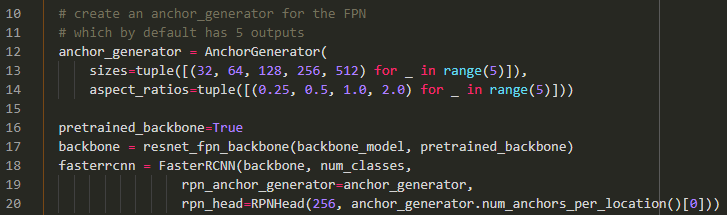
1. By removing the defult scale of 16 - Our images size equals to 1024 pixels so we wanted to increase efficiency and reduce time computation.
2. By setting the RPN head input to 256 (output of FPN)

Note: in that precticular notebook we are showing the training proccess of arbitrary model. 

In [11]:
backbones = ['resnet50', 'resnet101', 'resnet152']
CHOSEN_BACKBONE = backbones[0] #
fasterrcnn = load_resnet(CHOSEN_BACKBONE)

Save & load checkpoints

In [5]:
CHECKPOINT_DIR_PATH = '/content/gdrive/My Drive/Colab Notebooks/checkpoints/'

def save_checkpoint(checkpoint_name, model, optimizer, lr_scheduler, loss, epoch):
    path = CHECKPOINT_DIR_PATH + checkpoint_name 
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_loss': loss['train_loss'],
            'validation_loss': loss['validation_loss']
            }, path)
        print(f'Saved! {path}')
    except Exception as e:
        print(e)
        print('NOT save!')

def load_checkpoint(checkpoint_name, model, optimizer=None, lr_scheduler=None, warmup=False):
    path = CHECKPOINT_DIR_PATH + checkpoint_name 
    print(path)
    try:
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        if not warmup:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            train_loss = checkpoint['train_loss']
            validation_loss = checkpoint['validation_loss']
            epoch = checkpoint['epoch']
            print('Load!')
            return model, optimizer, lr_scheduler, train_loss, validation_loss, epoch
        else:
            print('Load!')
            return model
    except Exception as e:
        print(e)
        print('NOT load!')

# Schedulers:
A number of Schedulers were tested to accommodate some learning in training:

StepLR - which requires a lot of time for good adjusting the scheduler hyperparameters.
implemented cosine learing decay implementation from pytorch Schedulers which gave a different learning rate (compared to the optimizer learning rate and could not be used as mention in the git)
manual cosine learing decay implementation which that solve the problem and achieved a moderate reduction in learning rate throughout training and evalotion learning rate values ​​as the optimizers

[Cosine Learning rate decay](https://medium.com/@scorrea92/cosine-learning-rate-decay-e8b50aa455b)

[Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

We used cosine class for setting the optimizer learning rate to be equal the scheduler learning rate

In [14]:
from torch.optim.lr_scheduler import _LRScheduler
import math
# https://github.com/pytorch/pytorch/issues/17913
class LegacyCosineAnnealingLR(_LRScheduler):
    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:

    .. math::

        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))

    When last_epoch=-1, sets initial lr as lr.

    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.

    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.eta_min = eta_min
        super(LegacyCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * self.last_epoch / self.T_max)) / 2
                for base_lr in self.base_lrs]

# AdaMod
AdaMod is a stochastic optimizer that restricts adaptive learning rates with adaptive and momental upper bounds. The dynamic learning rate bounds are based on the exponential moving averages of the adaptive learning rates themselves, which smooth out unexpected large learning rates and stabilize the training of deep neural networks.

AdaMod is a drop in replacement for Adam. The only change is a new hyperparameter called B3, or Beta3. This controls the degree of lookback for the long term clipping average.

sources:
 * [An Adaptive and Momental Bound Method for Stochastic Learning](https://arxiv.org/pdf/1910.12249.pdf)

 * [Meet AdaMod: a new deep learning optimizer with memory](https://medium.com/@lessw/meet-adamod-a-new-deep-learning-optimizer-with-memory-f01e831b80bd)

#Set model & fine tuning Hyper-parameters
As we progressed, we used cross-validation on the hyper-parameters over 1-fold of our data. We notice that the optimal learning rate was 1e-4 with weight decay eqauls to 1e-4.

In addition, We checked the minimum learning rate for our scheduler.

In [15]:
### Preparing model for training

#Num of epochs
epochs = 40
fasterrcnn.to(device)
# Defininig Optimizer
optimizer = adamod.AdaMod(fasterrcnn.parameters(), lr=0.0001, weight_decay=0.0001, beta3=0.999)
# Learning Rate Scheduler
lr_scheduler = LegacyCosineAnnealingLR(optimizer, T_max=epochs)
lr_scheduler.eta_min = 1.0000000000000002e-07

#Training part:
For training part we used [Notebook](https://www.kaggle.com/jainamshah17/gwd-retinanet-pytorch-train) as reference.

In [ ]:
def train_one_epoch(epoch_num, train_data_loader):
    
    print("Train Epoch - {} Started".format(epoch_num))
    st = time.time()
    
    fasterrcnn.train()
    
    running_loss = 0
    total = 0
    for iter_num, (images, targets, image_ids) in tqdm(enumerate(train_data_loader), total=len(train_data_loader)):
                
        # Reseting gradients after each iter
        optimizer.zero_grad()
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward
        
        loss_dict = fasterrcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        
        running_loss += losses.item() * len(targets)
        total += len(targets)

        #Epoch Loss
        # epoch_loss.append(float(loss))
        if iter_num % 80 == 0:
            print(
                'Epoch: {} | Iteration: {} | Running loss: {:1.5f}'.format(
                    epoch_num, iter_num, running_loss / total))

            
    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    return running_loss / total

In [ ]:
### One Epoch - Valid

def valid_one_epoch(epoch_num, valid_data_loader):
    
    print("Validition Epoch - {} Started".format(epoch_num))
    st = time.time()
    
    epoch_loss = []
    total = 0
    running_loss = 0
    for iter_num, (images, targets, image_ids) in tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)):
                
        with torch.no_grad():
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward
            loss_dict = fasterrcnn(images, targets)
            
            # Calculating Loss
            losses = sum(loss for loss in loss_dict.values())

           

            running_loss += losses.item() * len(targets)
            total += len(targets)

            if iter_num %50 == 0:

                print(
                    'Epoch: {} | Iteration: {} | Running loss: {:1.5f}'.format(
                        epoch_num, iter_num, running_loss/total))

    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    return running_loss/total


In [ ]:
from pprint import pprint
model_losses = {
    'train_loss': [],
    'validation_loss': []
}
train_loss, validition_loss = [], []

epoches_range = range(epochs)

file_name = 'Fasterrcnn - ' + CHOSEN_BACKBONE +  f' fold: {VALIDATION_INDEX}' + '.pt'
load_file_path = file_name

#Check if file exists
if load_file_path:
    fasterrcnn, _, _, train_loss, validation_loss,  = load_checkpoint(load_file_path, fasterrcnn, 
                                                                      optimizer, lr_scheduler)
    [model_losses['train_loss'].append(l) for l in train_loss]
    [model_losses['validation_loss'].append(l) for l in validation_loss ]
    epoches_range = range((e+1), epochs, 1)
    pprint(model_losses)


for epoch in tqdm(epoches_range):
    fasterrcnn.train()
    tl, vl = 0, 0
    
    # Call train function
    tl = train_one_epoch(epoch, train_data_loader)
    model_losses['train_loss'].append(tl)
    
    # Call valid function
    vl = valid_one_epoch(epoch, valid_data_loader)
    model_losses['validation_loss'].append(vl)
    
    print('\n')
    print('*'*30)
    print(f'epoch: {epoch} learning rate {lr_scheduler.get_lr()[0]}\n Train loss{tl}\nvalidation loss {vl}')
    print('*'*30)
    print('\n')

    lr_scheduler.step()
    save_name = file_name
    #save every 10 epochs
    if epoch%10 == 0:
        save_name = f' epoch: {epoch}' + save_name 
        results={'model_state_dict':fasterrcnn.state_dict(),
         'model_losses':  model_losses}
        torch.save(results, CHECKPOINT_DIR_PATH + save_name)
    #Save checkpoint every epoch
    save_checkpoint(save_name, \
                    fasterrcnn, optimizer,\
                    lr_scheduler,\
                    model_losses, epoch)
results={'model_state_dict':fasterrcnn.state_dict(),
         'model_losses':  model_losses}
torch.save(results, CHECKPOINT_DIR_PATH + "-final-" + save_name)

In [ ]:
def show_results(train, validiton, figsiz=[10, 20]):
    X = len(train)
    plt.figure(figsize=figsiz)
    Epoches = np.linspace(1, X, X, dtype=np.int32)

    plt.plot(Epoches, train, label='train')
    plt.plot(Epoches, validiton, label='validition')
    plt.title("A Losses Curves", fontsize=24)
    plt.xlabel("Epoches ", fontsize=24)
    plt.ylabel("Loss", fontsize=24)
    plt.legend()
    plt.show()

show_results(model_losses['train_loss'], 
            model_losses['validation_loss'])  

As we can see below, our model is over-fit the data so we used our checkpoints saves to use the model at the desired epoch

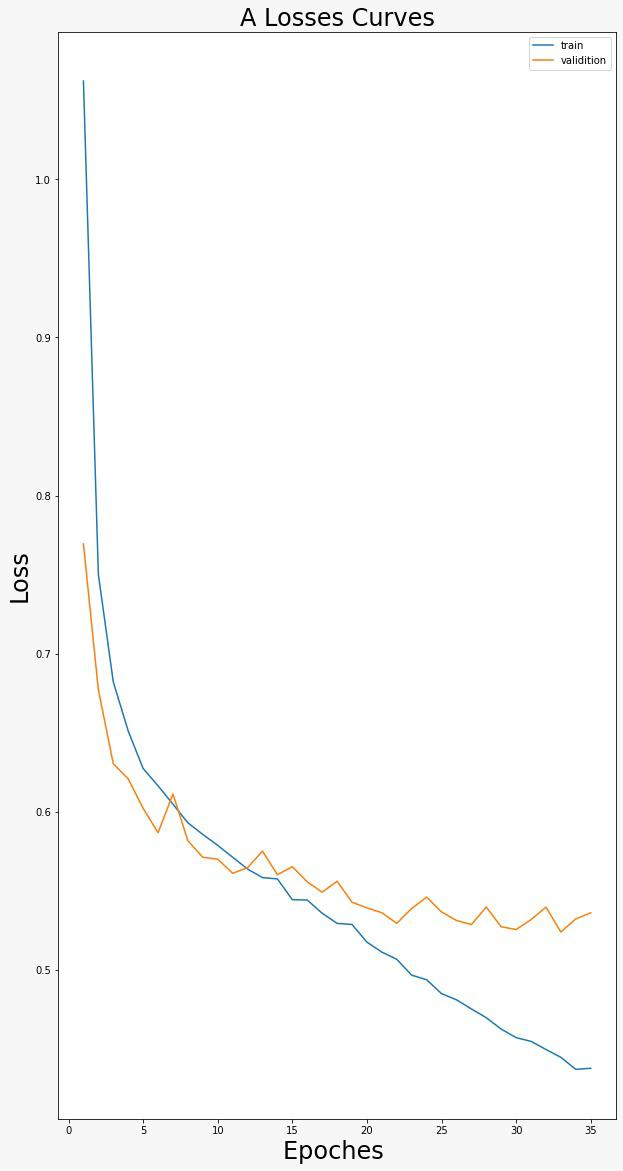